# Laboratory #06 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

# **Students** (First Name and Last Name)

1. Marc Gonzalez Vidal  
2. Oriol Miró Feliu-Lopez

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_path = '/content/drive/MyDrive/images/'

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import io, data
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Face Detection

## **Exercise #1:**

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Make sure that the values of the integral image are correct.
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [ ]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))


    # Add code here
    integral_image_arr[1:,1:] = np.cumsum(np.cumsum(img_arr, axis=1), axis=0)

    return integral_image_arr

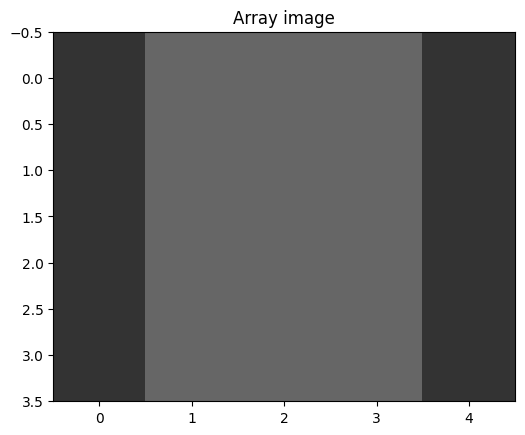

In [ ]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [ ]:
ii_img_array = compute_integral_image(img_array)
print(img_array)
print(ii_img_array)

[[1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]]
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

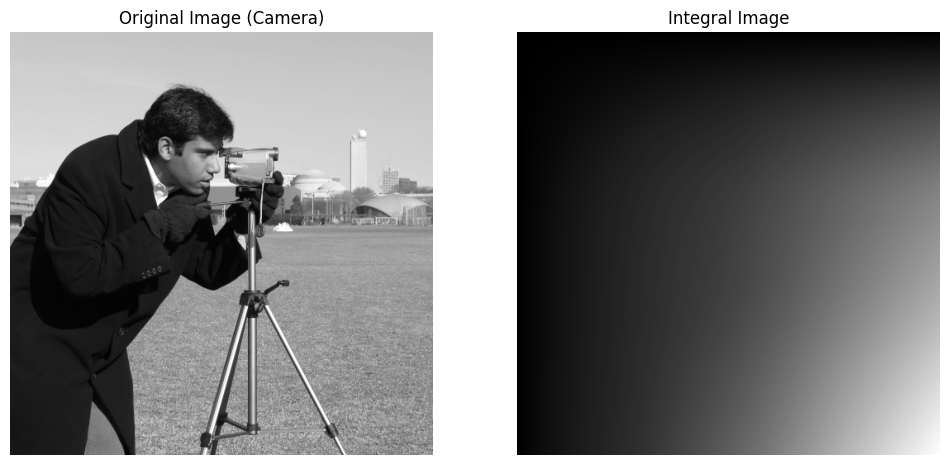

In [ ]:
camera_image = data.camera()

integral_image = compute_integral_image(camera_image)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(camera_image, cmap='gray')
plt.title("Original Image (Camera)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(integral_image, cmap='gray')
plt.title("Integral Image")
plt.axis("off")

plt.show()


## **Exercise #2:**

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [ ]:
def sum_region(integral_img_arr, top_left, bottom_right):

    # Code to complete
    x1, y1 = top_left
    x2, y2 = bottom_right

    return integral_img_arr[x2, y2] - integral_img_arr[x1, y2] - integral_img_arr[x2, y1] + integral_img_arr[x1, y1]

*   Make the following tests:

In [ ]:
# result you should get (12)
sum_region(ii_img_array, [1, 1], [3, 4])

12.0

In [ ]:
# result you should get (32)
sum_region(ii_img_array, [0, 0], [-1, -1])

32.0

## **Exercise #3:**

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [ ]:
def load_integral_images(path):
    images = []
    ii_images = []
    for _file in os.listdir(path):
       #### Complte here:
       #### Read image
       img = io.imread(os.path.join(path, _file))
       images.append(img)
       integral_image = compute_integral_image(img)
       #### Remember to scale the images (with the max pixel intensity value)
       maximum = np.max(integral_image)
       integral_image = integral_image / maximum
       ii_images.append(integral_image)

    return images, ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

In [ ]:
# change paths to your location

pos_training_path = base_path + 'train_data/faces'
neg_training_path = base_path + 'train_data/non_faces'
pos_testing_path = base_path + 'test_data/faces'
neg_testing_path = base_path + 'test_data/non_faces'

*   Visualize a few original images and the corresponding integral images using matplotlib.

<ipython-input-12-6f4f71e0d6e8>:12: RuntimeWarning: invalid value encountered in divide
  integral_image = integral_image / maximum


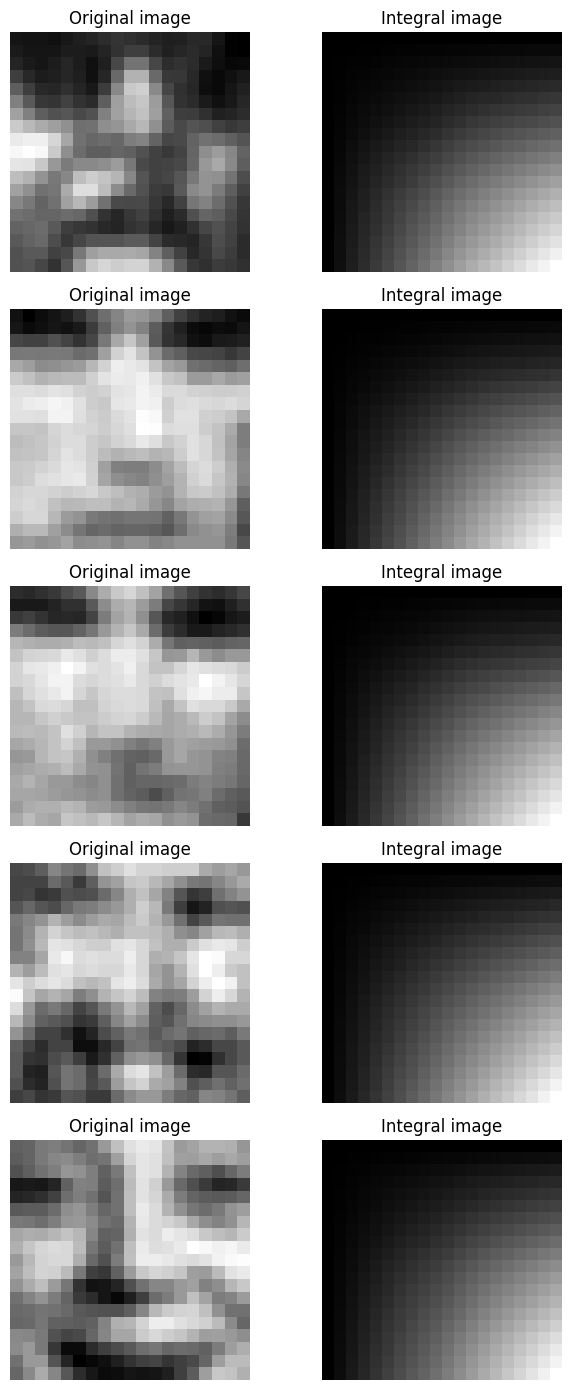

In [ ]:
# solution

pos_training_images, pos_training_iis = load_integral_images(pos_training_path)
pos_testing_images, pos_testing_iis = load_integral_images(pos_testing_path)
neg_training_images, neg_training_iis = load_integral_images(neg_training_path)
neg_testing_images, neg_testing_iis = load_integral_images(neg_testing_path)

fig, axes = plt.subplots(5, 2)

fig.set_size_inches(7,14)

for ax in axes.flatten():
    ax.axis("off")

for i, (img, ii) in enumerate(zip(pos_testing_images[:5], pos_testing_iis[:5])):
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    ax1.imshow(img, cmap="gray")
    ax1.set_title("Original image")
    ax2.imshow(ii, cmap='gray')
    ax2.set_title("Integral image")

fig.tight_layout()

## **Exercise #4:**

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [ ]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [ ]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1

    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score

    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [ ]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int

    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))


    print('\tTime needed for calculating scores:', time.time()-t0)

    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                for i in range(img_width - feature_width):
                    for j in range(img_height - feature_height):
                        features.append(HaarLikeFeature(feature, (i, j), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (i, j), feature_width, feature_height, 0, -1))

    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

## **Exercise #5:**

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [ ]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time
classifiers = learn(pos_training_iis, neg_training_iis, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.0073239803314208984
Calculating scores for images..
	Time needed for calculating scores: 456.86398482322693
Selecting classifiers..
	Time needed for Selecting Classifiers: 58.71531963348389 

CPU times: user 4min 17s, sys: 18.9 s, total: 4min 36s
Wall time: 8min 35s


## **Exercise #6:**

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [ ]:
# solution

def ensemble_vote(int_img, classifiers):
  return sum([classifier.get_vote(int_img) for classifier in classifiers]) > 0


def ensemble_vote_all(int_imgs, classifiers):
  return [ensemble_vote(int_img, classifiers) for int_img in int_imgs]

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
# solution
def calculate_results(classifiers, pos_iis, neg_iis):
    true_positives = sum(ensemble_vote_all(pos_iis, classifiers))
    true_negatives = len(neg_iis) - sum(ensemble_vote_all(neg_iis, classifiers))
    return true_positives, true_negatives

def display_results(label, classifiers, pos_iis, neg_iis):
    true_positives, true_negatives = calculate_results(classifiers, pos_iis, neg_iis)
    total_positives = len(pos_iis)
    total_negatives = len(neg_iis)
    print(f"{label} results:")
    print(f"  Correctly identified Faces: {true_positives}/{total_positives} ({100 * true_positives / total_positives:.2f}%)")
    print(f"  Correctly identified non-Faces: {true_negatives}/{total_negatives} ({100 * true_negatives / total_negatives:.2f}%)\n")

# Run and display results
display_results("train", classifiers, pos_training_iis, neg_training_iis)
display_results("test", classifiers, pos_testing_iis, neg_testing_iis)


train results:
  Correctly identified Faces: 2129/2429 (87.65%)
  Correctly identified non-Faces: 4282/8555 (50.05%)

test results:
  Correctly identified Faces: 38/50 (76.00%)
  Correctly identified non-Faces: 75/128 (58.59%)



## **Exercise #7:**

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time
classifiers_20 = learn(pos_training_iis, neg_training_iis, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Harr-like features: 0.010604143142700195
Calculating scores for images..
	Time needed for calculating scores: 447.9315195083618
Selecting classifiers..
	Time needed for Selecting Classifiers: 519.0769896507263 

CPU times: user 11min 47s, sys: 19.8 s, total: 12min 6s
Wall time: 16min 7s


train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4282/8555 (50.05260081823495%)

test results:
Correctly identified Faces: 38/50  (76.0%)
Correctly identified non-Faces: 75/128 (58.59375%)

In [ ]:
display_results("train", classifiers_20, pos_training_iis, neg_training_iis)
display_results("test", classifiers_20, pos_testing_iis, neg_testing_iis)

train results:
  Correctly identified Faces: 2216/2429 (91.23%)
  Correctly identified non-Faces: 7152/8555 (83.60%)

test results:
  Correctly identified Faces: 22/50 (44.00%)
  Correctly identified non-Faces: 104/128 (81.25%)



*   Discuss if the classification results improved in the train data.


**Solution**

The first thing that called our attention is that there is a massive improvement in the training set, particulary in the accuracy of non-face classifications. This improvement may be attributed as using a greater number of classifiers allows that each classifier can be specialized in a specific subset of images. However, allowing each classificer to be more specific have a cost, which is the risk of overfitting, and our results refelcts this trade-off. Altought, the accuracy in the training data have improved a lot, we see that in the test set they are not that good, especially in face identificacion, where performance decreased from a 76% to a 44% (on the test set). It is also important to mention, that this extreme overfit it's not seen in the non-Faces part, this can be attributed to the size of this set as we have many more non-face examples, helping avoid overfitting.

## **Exercise #8:**

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
# solution

def ensemble_vote_t(int_img, classifiers, threshold):
  return sum([classifier.get_vote(int_img) for classifier in classifiers]) > threshold


def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  return [ensemble_vote_t(int_img, classifiers, threshold) for int_img in int_imgs]

*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [ ]:
def get_results_with_threshold(classifiers, pos_iis, neg_iis, threshold):
    true_positives = sum(ensemble_vote_all_t(pos_iis, classifiers, threshold))
    true_negatives = len(neg_iis) - sum(ensemble_vote_all_t(neg_iis, classifiers, threshold))
    return true_positives, true_negatives

In [ ]:
# solution
results = []
thresholds = np.array([x for x in range(-5,5,1)])/10.

for threshold in thresholds:
  true_faces_train, true_non_faces_train = get_results_with_threshold(classifiers_20, pos_training_iis, neg_training_iis, threshold)
  true_faces_test, true_non_faces_test = get_results_with_threshold(classifiers_20, pos_testing_iis, neg_testing_iis, threshold)

  results.append({
        "Threshold": threshold,
        "Set": "Train",
        "Description": "Accuracy Faces",
        "Nº Correct": true_faces_train,
        "Nº Total": len(pos_training_iis),
        "Accuracy %": 100*true_faces_train/len(pos_training_iis)
  })

  results.append({
        "Threshold": threshold,
        "Set": "Train",
        "Description": "Accuracy Non-Faces",
        "Nº Correct": true_non_faces_train,
        "Nº Total": len(neg_training_iis),
        "Accuracy %": 100*true_non_faces_train/len(neg_training_iis)
  })

  results.append({
        "Threshold": threshold,
        "Set": "Test",
        "Description": "Accuracy Faces",
        "Nº Correct": true_faces_test,
        "Nº Total": len(pos_testing_iis),
        "Accuracy %": 100*true_faces_test/len(pos_testing_iis)
  })

  results.append({
        "Threshold": threshold,
        "Set": "Test",
        "Description": "Accuracy Non-Faces",
        "Nº Correct": true_non_faces_test,
        "Nº Total": len(neg_testing_iis),
        "Accuracy %": 100*true_non_faces_test/len(neg_testing_iis)
  })

df_results = pd.DataFrame(results)
print(df_results)

    Threshold    Set         Description  Nº Correct  Nº Total  Accuracy %
0        -0.5  Train      Accuracy Faces        2370      2429   97.571017
1        -0.5  Train  Accuracy Non-Faces        5893      8555   68.883694
2        -0.5   Test      Accuracy Faces          35        50   70.000000
3        -0.5   Test  Accuracy Non-Faces          84       128   65.625000
4        -0.4  Train      Accuracy Faces        2344      2429   96.500618
5        -0.4  Train  Accuracy Non-Faces        6209      8555   72.577440
6        -0.4   Test      Accuracy Faces          34        50   68.000000
7        -0.4   Test  Accuracy Non-Faces          89       128   69.531250
8        -0.3  Train      Accuracy Faces        2319      2429   95.471387
9        -0.3  Train  Accuracy Non-Faces        6436      8555   75.230859
10       -0.3   Test      Accuracy Faces          31        50   62.000000
11       -0.3   Test  Accuracy Non-Faces          94       128   73.437500
12       -0.2  Train     

*   Make a bar plot for 1-4. In the x axis write the threshold value.

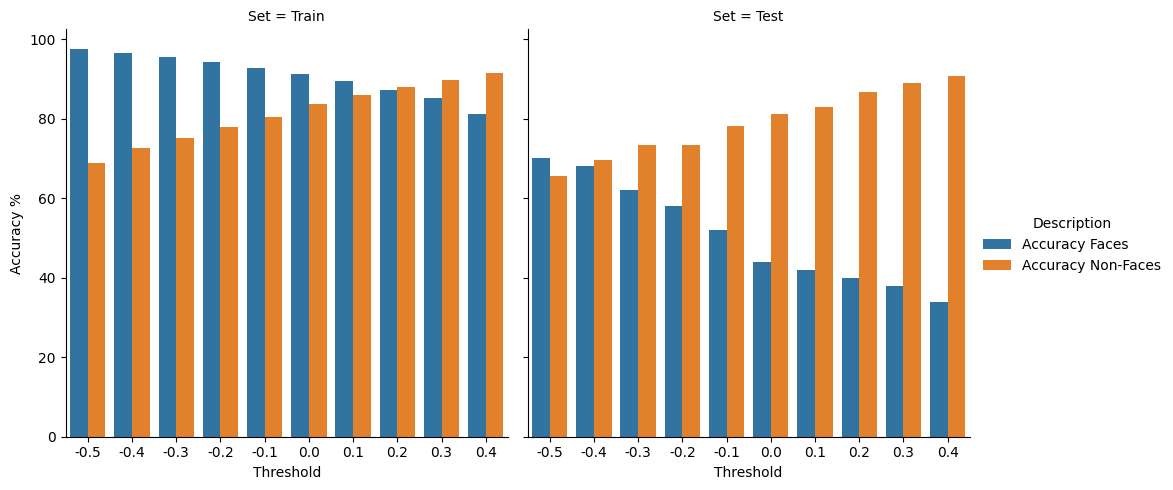

In [ ]:
# solution
sns.catplot(data=df_results, x="Threshold", y="Accuracy %", hue="Description", kind="bar", col="Set");

*   Discuss what happens when you increase the threshold value.

**Solution**

As shown in the graph, increasing the threshold makes it more challenging for the model to detect faces while simultaneously improving the detection accuracy of non-face instances. This trend is observed consistently across both the train and test sets. This behavior aligns with expectations, as a higher threshold in the voting system requires more classifiers to agree on the presence of a face, which increases the likelihood of false negatives.

Furthermore, the accuracy for non-faces in the test set falls much more steeply as the threshold increases, compared to the train set. This is likely due to slight overfitting, where the model learns to better classify specific training examples of non-faces by focusing on challenging cases.

# Face Recognition

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 966 faces
done in 1.075s


In [ ]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.040s


In [ ]:
# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 22.632s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.01)


In [ ]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.042s


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.69      0.82        13
     Colin Powell       0.84      0.90      0.87        60
  Donald Rumsfeld       0.94      0.63      0.76        27
    George W Bush       0.81      0.97      0.88       146
Gerhard Schroeder       0.90      0.72      0.80        25
      Hugo Chavez       1.00      0.60      0.75        15
       Tony Blair       0.93      0.69      0.79        36

         accuracy                           0.85       322
        macro avg       0.92      0.74      0.81       322
     weighted avg       0.86      0.85      0.85       322



In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   1   0   3   0   0   0]
 [  0  54   0   6   0   0   0]
 [  0   1  17   9   0   0   0]
 [  0   4   0 142   0   0   0]
 [  0   0   0   5  18   0   2]
 [  0   3   0   3   0   9   0]
 [  0   1   1   7   2   0  25]]


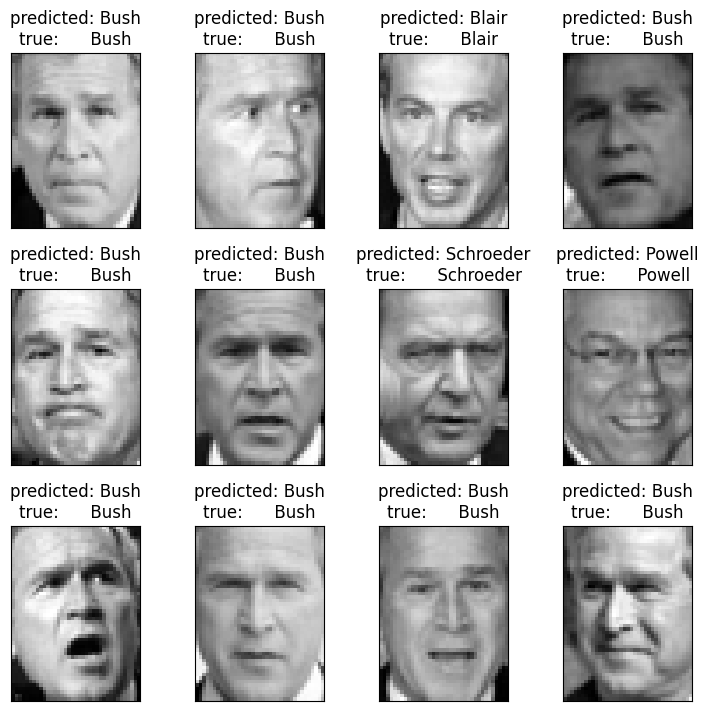

In [ ]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

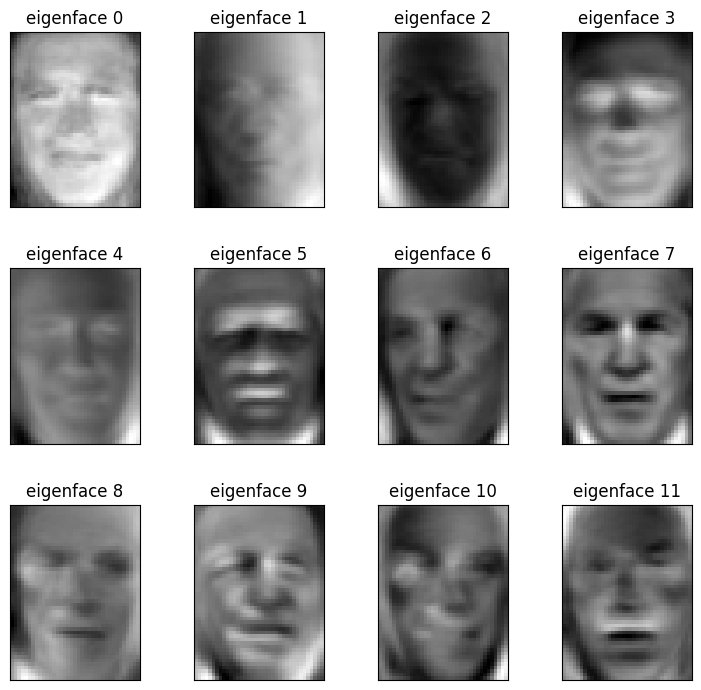

In [ ]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## **Exercise #1:**

*   Show the total percentage of variance explained by the selected components of the PCA.


In [ ]:
# solution

explained_variance_ratio = pca.explained_variance_ratio_
total_variance_explained = explained_variance_ratio.sum() * 100
print(f"Total percentage of variance explained by the selected components: {total_variance_explained:.2f}%")

Total percentage of variance explained by the selected components: 91.55%


## **Exercise #2:**

*   Explain all the measures showed in the classification report.
*   Discuss the obtained classification results, the quantitative as well as the qualitative results.
*   Comment the showed eigenfaces.



**Solution**

In the classification report, three measures are shown to understand how the model is performing: precision, recall, and f1-score.

- **Precision** measures how many of the predicted true labels are actual true labels.  
- **Recall** measures how many of the actual true labels are correctly predicted.  
- **F1-score** is a trade-off between the two, combining both metrics using the harmonic mean. It's very usefull when minority classes are present in our dataset.
- **Support** represents the number of examples of each class that exist in the dataset.

$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$

$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$

$
\text{F1-score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$

It is shown that this approach works quite well, achieving an overall accuracy of 0.86 based on the F1-score, which is the most relevant metric for this dataset as it is imbalanced. It is also important to notice that the classes that are better classified tend to have more instances in the dataset, indicating a direct correlation between the F1-score of a class and the number of instances it contains.

Regarding the eigenfaces, almost all of them highlight distinguishing features of George Bush, as his class is the most representative one in the dataset. PCA is designed to capture and preserve the maximum variance in the data, regardless of class, which means that the first few principal components (eigenfaces) primarily encode the features most frequently observed in the largest class. As a result, the initial eigenfaces strongly emphasize the variations within the George Bush class.

## **Exercise #3:**

*   Change the strategy for dimensionality reduction from PCA to LDA.
*   *Hint: You can use sklearn.discriminant_analysis.LinearDiscriminantAnalysis*

In [ ]:
# solution

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=n_classes-1).fit(X_train, y_train)

X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_lda, y_train)

y_pred = clf.predict(X_test_lda)
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.68      0.70      0.69        60
  Donald Rumsfeld       0.49      0.63      0.55        27
    George W Bush       0.89      0.72      0.80       146
Gerhard Schroeder       0.55      0.64      0.59        25
      Hugo Chavez       0.50      0.67      0.57        15
       Tony Blair       0.60      0.69      0.64        36

         accuracy                           0.69       322
        macro avg       0.60      0.67      0.63       322
     weighted avg       0.72      0.69      0.70       322



In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  8   2   2   0   1   0   0]
 [  3  42   2   5   4   3   1]
 [  1   2  17   1   0   1   5]
 [  3  14  12 105   3   2   7]
 [  0   0   1   3  16   3   2]
 [  0   0   0   2   1  10   2]
 [  1   2   1   2   4   1  25]]


*   How many dimensions are we obtaining in the new space? Why?
*   Comment the results and compare them with the ones obtained with PCA.
*   Explain which is the main difference between the two approaches.

**Solution**

We are obtaining a space with dimensionality n_classes - 1. LDA seeks to find a linear transformation that maximizes class separability by projecting the data onto a lower-dimensional space. The goal is to find discriminant axes that separate classes while minimizing within-class scatter. Since there can only be n_classes - 1 independent directions that distinctively separate the data in a high-dimensional space, the resulting space will have at most n_classes - 1 dimensions.

The results obtained using LDA are worse than those with PCA, with the average F1-score for LDA being 0.69, compared to 0.86 for PCA. One possible explanation is that the dataset is relatively small for these approaches, or, more critically, that it is highly imbalanced, with George Bush being overrepresented. This imbalance can lead to suboptimal class separation with LDA, as the method may favor classes with more examples.

The main difference between PCA and LDA is their nature: PCA is unsupervised, while LDA is supervised. LDA uses class labels to reduce dimensionality in such a way that points from the same class cluster together, while points from different classes are pushed farther apart. In contrast, PCA ignores class labels and focuses solely on finding directions of maximum variance in the feature space. This means that, in theory, LDA should outperform PCA in classification tasks. However, for LDA to perform well, it requires a larger and more balanced dataset. With an imbalanced dataset like this one, PCA's focus on variance rather than class separation may produce better results.


---

# **End of P6: Face detection and recognition**

This notebook is part of **Deliverable 3**

Deadline for Deliverable 3 (P6 and P7) submission in CampusVirtual is: **Monday, the 18th of November, 2024**
